<a href="https://colab.research.google.com/github/veren4/SMILES_featurization/blob/master/My_LSTM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The approach in this notebook is based on [this article](https://www.cheminformania.com/building-a-simple-smiles-based-qsar-model-with-lstm-cells-in-pytorch/). It doesn't use Torchtext. Most text in this notebook is copied from the article.

pro: adapted for large datasets -> doesn't overload RAM

con: augments the data?\
split into train, test, validate

\
The aforementioned tutorial is for a QSAR model and creates a loss by training for a molecular property (pXC50). That is not what I want; I want to create a self-supervised model. Therefore, I create a target according to [this tutorial](https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-11-30 10:39:44--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-11-30 10:39:44--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import platform

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Python: ', platform.python_version())
print('PyTorch: ', torch.__version__)
if(device.type == 'cuda'):
  print('Using GPU (cuda)')
else:
  print('Using CPU!')

Python:  3.6.9
PyTorch:  1.7.0+cu101
Using GPU (cuda)


# Data import & preparation

In [5]:
infile = '/content/drive/My Drive/Rostlab internship/7_PyTorch/Untokenized_dataset.tsv'

with open(infile, "r") as file1:
    data = pd.read_table(file1)

file1.close()

In [6]:
#data.head(2)

RDKit will be used as the molecular format for MolVecGen, a package for SMILES based vectorization of molecules and we’ll start by converting the SMILES to RDKit molecular objects. The pandastools module contain a convenient function for creating a molecule column, that also makes the column work with nicely with Jupyterlab and notebooks.

In [7]:
PandasTools.AddMoleculeColumnToFrame(data,'SMILES','Molecule')
#data[["SMILES","Molecule"]].head(2)

In [8]:
from rdkit.Chem.Descriptors import MolWt

In [9]:
data['molecular_weight'] = 0

for row in range(len(data.index)):
  data.iloc[row,2] = MolWt(data['Molecule'][row])

#Vectorizing the SMILES with data augmentation

As just mentioned above, I’ll use the MolVecGen package to vectorize the SMILES. The package was originally written to work with Keras generators during training. However, generators can no longer be used in Keras, but the vectorization class that converts SMILES into one-hot encoded tensors can easily be adapted to work with PyTorch.

In [10]:
!pip install -q git+https://github.com/EBjerrum/molvecgen.git

In [11]:
from molvecgen.vectorizers import SmilesVectorizer

The object is initialized with the generation parameters and subsequently fitted to the dataset. This analyzes the dataset for what characters it contains and the maximal length. As the augmentation can result in longer SMILES strings as well as the appearance of some additional characters, some extra padding and characters may be needed to avoid too many “?” which are unknown characters. It doesn’t appear to be a huge issue for this dataset.

In [12]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=True, augment=False)
smivec.fit(data.Molecule.values, )

After fitting we can inspect the charachter set and the dimensions of the produced one-hot encoded SMILES including the padding

In [13]:
print(smivec.charset)
smivec.dims

S3-C1O2NnH#c4l)=P][(+^$?


(108, 24)

^ SOL\
$ EOL\
? unknown

Before we start to manipulate the dataset with normalization it’s important to split into train, validation (development) and test sets. Scikit-learn, contains some convenient functions to split into different sets as well as normalize the target values.

In [14]:
list(data.columns.values)

['SMILES', 'Molecule', 'molecular_weight']

Was ist pXC50?:\
In addition to the conversion of published activity types/values/units to standard activity types/values/units, we have now added an additional field called pChEMBL to the Activities table. This value allows a number of roughly comparable measures of half-maximal response concentration/potency/affinity to be compared on a negative logarithmic scale. For example, an IC50 measurement of 1nM would have a pChEMBL value of 9. pChEMBL is defined as: -Log(molar IC50, XC50, EC50, AC50, Ki, Kd or Potency).

pXC50 = half-maximal response potency to be compared on a negative logarithmic scale.

In [15]:
y = data.molecular_weight.values.reshape((-1,1))
X = data.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)

PyTorch works with datasets, and we can easily integrate the vectorizer by subclassing the __getitem__ method and the __len__method. This way we can load the dataset with RDKit molecular objects and generate the tensors on the fly. This allows us to use SMILES augmentation on the fly without pre vectorizing the dataset. This is a small overhead during training, but it is convenient and allows to handle huge datasets without running out of memory.

In [16]:
#predictors = X_train[0:-1]  # erstes Element bis vorletztes
#label = X_train[1:]        # zweites Element bis letztes
##label = ku.to_categorical

In [17]:
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

#Wrapping the SMILES vectorizer in a PyTorch dataset

In [18]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

Now we can create and work with the dataset. Calling the first items returns the vector and the target value. Calling it again will most probably result in a different augmented SMILES tensor as we turned on augmentation.

In [19]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8), array([-0.36134067]))

The validation set will be calculated and kept fixed, it’s merely used to monitor for potential overfitting. Let’s get those arrays transfered to the GPU memory as tensors.

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
X_validation_t.shape

cuda:0


torch.Size([5, 108, 24])

#Defining the PyTorch LSTM molecular model

Having the datasets and preprocessing in place it’s time for the fun part. Defining the neural network architecture. I’ve kept this really simple with just a single layer of LSTM cells and a bit of dropout for conteracting over-fitting.

In [21]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
         
        length = dims[0]
        number_tokens = dims[1]
         
     
        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

    def get_hidden_state(self, x):
        out, (h_n, c_n) = self.lstm(x)
        return h_n, c_n          # h_n oder c_n?

Lets define some parameters that will control the size and dropout of the network. These ideally needs to be tuned with some algorithm, but here I simply choose some parameters based on a bit of experimenting.

In [22]:
epochs = 50
dims = smivec.dims
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.50 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 128   # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer

In [23]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

Net(
  (lstm): LSTM(24, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

A quick test to see that the network is working is to predict a sample from the validation set, as this is already vectorized. The output will probably not be right, but it will show that the networks tensors are at least not having technical errors in the way they are connected

In [24]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([], device='cuda:0', size=(1, 0, 1), grad_fn=<AddBackward0>)

Mean square error is a reasonable loss function for regression tasks, and Adam will be used to optimize the weights. A learning rate scheduler will lower the loss once the validation loss stops to improve.

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, 
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

The train dataset will be used together with a PyTorch dataloader to provide randomly selected mini-batches for the training.

In [26]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)

A quick test of the train_loader which also provides us with some samples to work if needed for trouble shooting.

In [27]:
for smiles in train_loader:
    break

#Training the PyTorch SMILES based LSTM model

In [28]:
#!pip install torch-nightly
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html


In [30]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        # Push numpy to CUDA tensors 
        smiles = torch.tensor(smiles, device=device).float() #.cuda()
        labels = torch.tensor(labels, device=device).float() #.cuda()
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass
         
        output = model(smiles) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    else:
         
         
        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()
         
        lr_scheduler.step(validation_loss)
         
        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%10 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))

print("Training done!")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([81, 1])) that is different to the input size (torch.Size([1, 81, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10, Training loss: 0.99 Validation loss: 1.56
Epoch 20, Training loss: 0.31 Validation loss: 0.14
Epoch 30, Training loss: 0.33 Validation loss: 1.63
Epoch 40, Training loss: 0.34 Validation loss: 0.15
Epoch 50, Training loss: 0.32 Validation loss: 0.05
Training done!


In [43]:
hidden

NameError: ignored

After training we can plot the training. It looks a little overfit as the validation loss is diverging and maybe rising a bit in the end. Changing the hyperparameters and retraining could work, but it can be tedious to find the excact right parameter, so a optimization library is recommended.

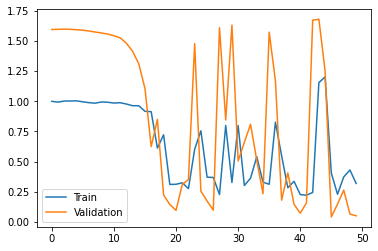

In [31]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

#Evaluating the performance

The model is switched into evaluation mode and some statistics are calculated in the form of root mean square error (RMSE).

In [32]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)

torch.mean(( y_validation_t - y_pred_validation )**2).item()

0.05049793794751167

Let’s also vectorize the train and test sets and see how they perform.

In [33]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()

y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.242	Test RMSE: 0.426


A visual plot of the predicted versus real values can also help estimate the goodnes of the fit.

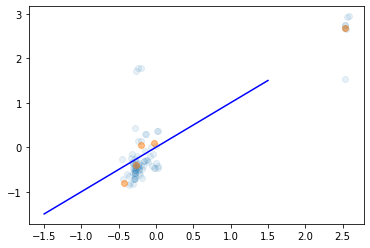

In [34]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

**Compared** to the fingerprint feed forward network, this model seems to be slightly worse. Deep learning usually require a lot of data, and this dataset may not cut the bill in size. Alternative more tuning is needed to get the right hyperparameters for the networks, such as learning rate, dropout, networksize, etc. But reading in SMILES can be used in a lot of other interesting architectures, and this model illustrates the foundation for reading-in molecules in SMILES format for a PyTorch based artificial neural network.

#Extract the state of the LSTM

The model is already in eval mode, as this is done after training.

In [51]:
model.eval()

Net(
  (lstm): LSTM(24, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [44]:
hidden_state, cell_state = model.get_hidden_state(smiles)

In [45]:
hidden_state

tensor([[[ 0.0183,  0.0024, -0.0494,  ...,  0.0205, -0.0667, -0.0171],
         [-0.0245, -0.0167, -0.1111,  ...,  0.0087, -0.1354, -0.0317],
         [-0.0279, -0.0092, -0.1307,  ...,  0.0117, -0.1148, -0.0465],
         ...,
         [-0.0071, -0.0039, -0.0807,  ...,  0.0151, -0.0934, -0.0330],
         [-0.0393, -0.0050, -0.1821,  ...,  0.0010, -0.1559, -0.0641],
         [-0.0241, -0.0106, -0.1224,  ...,  0.0114, -0.1096, -0.0647]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward>)

In [46]:
cell_state

tensor([[[ 0.0385,  0.0048, -0.0975,  ...,  0.0411, -0.1432, -0.0361],
         [-0.0539, -0.0323, -0.2222,  ...,  0.0174, -0.3059, -0.0668],
         [-0.0610, -0.0177, -0.2606,  ...,  0.0236, -0.2565, -0.0983],
         ...,
         [-0.0152, -0.0077, -0.1594,  ...,  0.0303, -0.2049, -0.0693],
         [-0.0892, -0.0096, -0.3721,  ...,  0.0021, -0.3636, -0.1372],
         [-0.0525, -0.0207, -0.2419,  ...,  0.0231, -0.2451, -0.1363]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward>)